<font size=6>**DL Regression**</font> </h6>

<div style="border: 1px solid lightgray; padding: 10px; background-color: #f9f9f9;">

<font size=1>

    Summer School for AstroStatistics in Crete, 2025

The content presented in this notebook is the original work of the authors, unless specified otherwise.
Any publicly available material incorporated is properly credited to its respective sources.
All references to published papers, datasets, and software tools are duly acknowledged.
The original content of this notebook is licensed under the GNU General Public License v3.0 (GNU GPLv3).
</font>
</div>

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

In this session we provide a short introduction to **Regression**, a topic which can be covered by both machine learning applications (such as those in [scikit-learn](https://scikit-learn.org/stable/index.html) we saw in clustering and classification session) and deep learning approaches. <br>
The goals are:

- to get an idea of how we **build and train** a deep learning model
- explore some **basic concepts** to better understand their use and impact. 

In the example that will follow we are mainly going through these steps:

    1. Load and Select Data
    2. Define Model
    3. Compile Model
    4. Fit Model 
    5. Iterate steps 2-3-4 (by adjusting various parameters or the model architecture)
    6. Evaluate Model
    7. Make Predictions


In [35]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Set up a fancy plot style (you can comment it out without consequences)
import sys; sys.path.append('../src'); import plot_style

import warnings
warnings.filterwarnings(action='ignore')

import time

import keras
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization,Conv3D, MaxPooling3D, Dense, Add, Activation
from keras.regularizers import l2
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, Adagrad, RMSprop

from astropy.io import fits
from astropy.table import Table

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from IPython.display import clear_output


# What is regression ?

    Modeling problems where the output is a continuous numeric value.


# Linear regression and least squares

A linear regression model will try to predict the single value of the dependent variable $y$ given the independent variable $x$, with the most generic form being: 

$$y = f (x | β), $$

where $x$ corresponds to the input variable(s) and $β$ is an array of parameters.

The simplest linear model we can think of is a line:

$$y = β_0 + β_1 x $$

where $β_0$ and $β_1$ have the usual meaning of intercept and slope of a line. 

Generalizing a bit, for an input vector $x^T = (x_1, x_2, ..., x_N)$,  where $N$ is the total number of observations (or samples), the linear model to predict the real-valued output $y$ is:

$$ f(x) = β_0 + \sum_{i=1}^{N} x_i β_i. $$

To find these parameters we use the Ordinary Least Squares approach, i.e. we try to **minimize** the residual sum of the squares between the observations and the predictions by the model (i.e. the **loss or cost** function):

$$ RSS(β) = \sum_{i=1}^{N} (y_i - f(x_i))^2 =  \sum_{i=1}^{N} (y_i - β_0 - x_i β_i)^2 .$$




# The more general linear regression

Linear regression refers to modeling functions that are linear with respect to the parameters (coefficients) and not with respect to the variables! For example, the function:

$$f (x|β) = \sum_{i=1}^N β_i g_i(x) = β_1 g_1(x) + β_2 g_2(x)~+~...~+~β_N g_N(x) $$

describes a linear problem as long as the sub-functions $g_i(x)$ do not depend on any of the parameters $β_i$. This is not the most generic formulation of the linear regression but we are going to use this form in the following applications.

# On metrics ... or how well can we do

> _Accuracy is a measure for classification not regression_<br>
> _We cannot calculate accuracy for a regression model_
>
>  _by Jason Brownlee [Regression Metrics for Machine Learning](https://machinelearningmastery.com/regression-metrics-for-machine-learning/)_

In regression we are dealing with continuous values. Therefore, it is actually impossible to predict the exact same values. The idea is to get an estimate of how close the predictions are to the expected values.

We are going to refer only a few of the available metrics in [sklearn](https://machinelearningmastery.com/regression-metrics-for-machine-learning/). In the following $y$ refers to the dependent values while $\hat{y}$ to the predicted values.

**--> Mean Squared Error (MSE)**

$$ MSE = \frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y_i})^2 $$  

It is actually the cost function of the Ordinary Least Squares (check $RSS(β)$ above). The units returned in this case are squared. Best score is 0.

**--> Root Mean Squared Error (RMSE)**

$$ RMSE = \sqrt{ \frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y_i})^2 } $$  

It returns the square root of MSE so that the units match the units of the target value (so better interpretation).  Best score is 0.

**--> Mean Absolute Error (MAE)**

$$ MAE = {1 \over N}\sum_i^N{|  y_i-\hat{y_i} |}$$  

It is less sensitive to large errors when compared to (R)MSE. The score is in units of the target value.

> Comment: Although arithetically the best scores for (R)MSE and MAE is 0 this cannot be the case in real-life problems. Instead a baseline model has to be determined and calculate its score. Then, any model that can achieve a score better that the baselie model is accepted as a skilful model.  


**--> R2 (coefficient of determination)**

$$R^2 = 1 - {\sum_{i=1}^N{(y_i-\hat{y_i})^2} \over \sum_{i=1}^N{(y_i - \bar{y})^2}}, $$ 

where $\bar{y} = \frac{1}{n}\sum_{i=1}^N y_i$. 

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 


# Application 1: Estimate SFR

We will use data derived from the Heraklion Extragalactic Catalogue (HECATE; [Kovlakas et al, 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.506.1896K/abstract)) which is an all-sky galaxy catalogue, containing about 200k galaxies (up to z=0.047, D≲200Mpc), and it offers positions, sizes, distances, morphological classifications, star formation rates, stellar masses, metallicities, and nuclear activity classifications. 

In particular, we are going to use a dataset from the work of [Kouroumpatzakis et al. 2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...673A..16K/abstract) where they estimate the Star Formation Rates (SFR) and stellar mass using model Spectral Enerny Distributions with a variety of parameters (IR photometry, extinction, and stellar populations). 

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
<font size=4>**Exercise 1:**</font>    

**Objective:** Build a regression model to predict SFR

**Task:** For this follow these steps:
    
- load and investigate the data
    
- select features
    
- pre-process the data
    
- split data (train/validation/test)
    
- build model (architecture with dense layers)
    
- train the model
    
- evaluate its performance
    
- compare with baseline model and check results.    

</div>


## Loading and checking data 

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
# import time

# import keras
# from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization,Conv3D, MaxPooling3D, Dense, Add, Activation
# from keras.regularizers import l2

# from keras.models import Model, Sequential
# from keras.optimizers import Adam, SGD, Adagrad, RMSprop
# from sklearn.metrics import r2_score

# from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    # NOTE: the current version can print only the first metric from the list provided
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.losses2 = []
        self.val_losses2 = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.losses2.append(logs.get( test_metrics[0] ) )
        self.val_losses2.append(logs.get( f'val_{test_metrics[0]}' ))
#         print(test_metrics[0] , logs.get( test_metrics[0] ), logs.get( f'val_{test_metrics[0]}' ))
#         print(self.losses2)

        self.i += 1
        
        clear_output(wait=True)
        plt.subplot(1,2,1)
        plt.plot(self.x, self.losses2, label="Train",linestyle='-')
        plt.plot(self.x, self.val_losses2, label="Validate",linestyle='--')
#        plt.ylim(0,1)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel(test_metrics[0])
        
        plt.subplot(1,2,2)
        plt.plot(self.x, self.losses, label="Train",linestyle='-')
        plt.plot(self.x, self.val_losses, label="Validate",linestyle='--')

        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.tight_layout()
        
        plt.show();
        
plot_losses = PlotLosses()


def sub_ploots(plots_cols, plots_array):
        """ Automatic adjustment of subplots
        Given the 
        plots_cols     : plots per row (set manually)
        plots_array    : array from which the number of 
                         individual subplots is derived

        the output is given as 
        plots_cols     : plots per row
        plots_rows     : number of necessary rows to create
        """
        plots_unique = len((list(set(plots_array))))
        plots_rows = int(np.ceil(plots_unique/plots_cols))
        
        return plots_rows, plots_cols

In [3]:
# following this tutorial :https://learn.astropy.org/tutorials/FITS-tables.html

data_fits = fits.open('data/CIGALE_SFR.fits', memmap=True)

# printing some information 
data_fits.info()
print('-----')
print(data_fits[1].columns)

Filename: data/CIGALE_SFR.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (911,)   uint8   
  1  /home/grigoris/Projects/AstroStatisticsCrete-2025/2025_summer_sch...    1 BinTableHDU     34   123908R x 11C   [D, D, D, D, D, D, D, D, D, D, D]   
-----
ColDefs(
    name = 'sfr'; format = 'D'
    name = 'mstar'; format = 'D'
    name = 'IRX'; format = 'D'
    name = 'EBVs'; format = 'D'
    name = 'LYoungOld'; format = 'D'
    name = 'NIR200'; format = 'D'
    name = 'MIRI2100'; format = 'D'
    name = 'W1'; format = 'D'
    name = 'W2'; format = 'D'
    name = 'W3'; format = 'D'
    name = 'W4'; format = 'D'
)


**Note on columns:**

```
       'sfr' : Star Formation Rate
     'mstar' : Stellar Mass
       'IRX' : IR excess ratio 
      'EBVs' : extinction
 'LYoungOld' : ratin of luminosity of young to old populations
   'NIR200' : JWST NIR-F200W
 'MIRI2100' : JWST MIRI-F2100W
       'W1' : WISE 3.4 μm 
       'W2' : WISE 4.6 μm 
       'W3' : WISE 12 μm 
       'W4' : WISE 22 μm 
```

Printing the data table. 


In [4]:
data_tab = Table(data_fits[1].data)
data_tab

sfr,mstar,IRX,EBVs,LYoungOld,NIR200,MIRI2100,W1,W2,W3,W4
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-1.7775958737441702,8.88439002050874,1.0597066442746876,0.075,-1.161582684412036,20.57568201275021,20.915356290620906,20.283857754272237,20.07785242628705,20.749168886908052,20.977838069609653
-5.598150103513504,7.163475768985803,0.6090525930420546,0.075,-3.095438541121911,18.699843670803883,18.71021154983641,18.380386821972536,18.169375587980156,18.556209527608885,18.77235612162204
0.46026919969367264,9.555252512015649,1.902715602377176,0.12,-0.007993003792127648,21.24489484510881,22.644248708956212,21.234736799549726,21.25041706188928,22.46532446497027,22.707373655941282
2.4145309631249785,10.32453156040969,1.399250989811699,0.06,0.59695867241776,23.240506755171285,24.305480238065996,23.0619764044172,23.01596122061309,24.127836105292985,24.356805745021273
-3.2602550268517,8.694262138626932,1.5825219675250681,0.24,-2.6966069354956685,20.478382255352365,21.17948475308555,20.222128818087356,20.063940269851575,21.003583359324065,21.242689708753176
-3.8229180838972106,8.827694847737332,0.794228535480207,0.06,-2.6499464090799667,20.175890232692996,20.04636052688319,19.85353655051953,19.621751170933265,19.900476164368083,20.10778046646713
0.8506413438533907,9.465027116409965,1.6451465950450486,0.12,0.42176281956076034,21.583159957555335,22.862224270730703,21.464771982664036,21.462010041607755,22.70072019878477,22.917040470013063
0.3212462542445377,8.46334364974829,1.9219557531126592,0.195,1.943541695128508,20.53529154234542,22.23356572282868,20.641662695014567,20.73772356328627,22.06708673225438,22.29388843053493
0.34317898627799476,8.287711611276643,1.9519193931772922,0.18,0.38600979614344816,20.545438547880376,22.456827133479848,20.8170107257701,20.952689859912386,22.277083741941293,22.519956006914548


## Selecting features

In this part we can select which features we want to keep and use to train our model. Feel free to choose any number of feature - keep in mind though **NOT** to select `sfr` and `mstar` as these are needed for the output (i.e. are the values we want to predict).


<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** select the features to work with

</div>


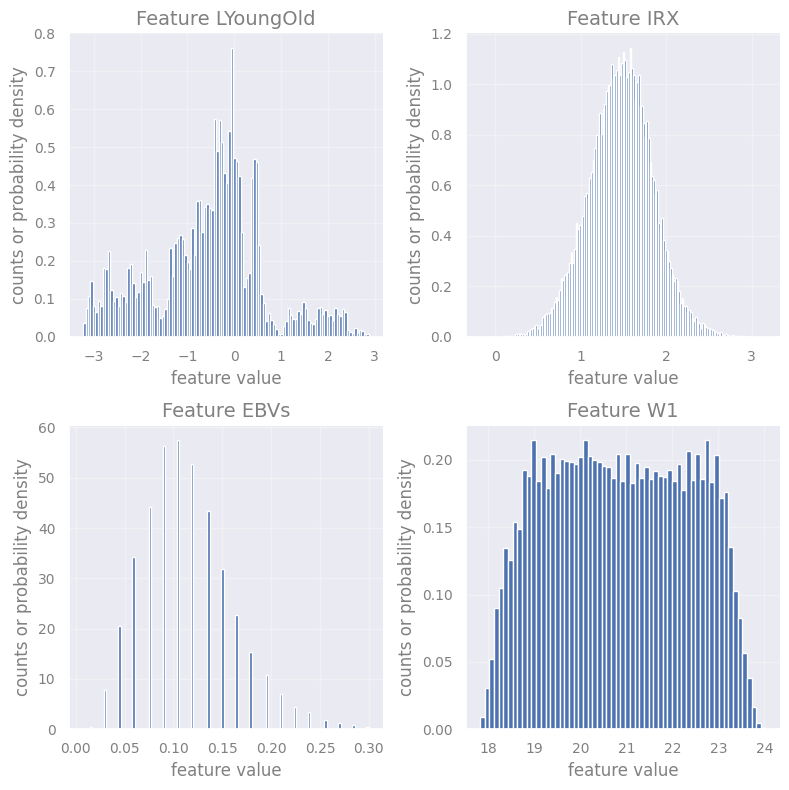

In [5]:
sel_features = ['LYoungOld', 'IRX', 'EBVs', 'W1'] 

fig = plt.figure(figsize=(8,8))

rws, cls = sub_ploots(2, sel_features)  # for subplots
for f in range(len(sel_features)):
    f_name = sel_features[f]
    ax = fig.add_subplot(rws, cls, f+1)
    ax.set_title(f'Feature {f_name}')
    ax.hist(data_tab[f_name], bins='auto', align='mid', density=True)
    ax.set_xlabel('feature value')
    ax.set_ylabel('counts or probability density')

plt.tight_layout()
plt.show()

In [6]:
len(data_tab)

123908

and the data table with the _selected features_ looks like ...

In [7]:
data_tab[sel_features]

LYoungOld,IRX,EBVs,W1
float64,float64,float64,float64
-1.161582684412036,1.0597066442746876,0.075,20.283857754272237
-3.095438541121911,0.6090525930420546,0.075,18.380386821972536
-0.007993003792127648,1.902715602377176,0.12,21.234736799549726
0.59695867241776,1.399250989811699,0.06,23.0619764044172
-2.6966069354956685,1.5825219675250681,0.24,20.222128818087356
-2.6499464090799667,0.794228535480207,0.06,19.85353655051953
0.42176281956076034,1.6451465950450486,0.12,21.464771982664036
1.943541695128508,1.9219557531126592,0.195,20.641662695014567
0.38600979614344816,1.9519193931772922,0.18,20.8170107257701


We convert table objects into numpy arrays:


In [8]:
values = data_tab[sel_features].as_array()
values = values.view((float, len(values.dtype.names)))
target = np.array(data_tab['sfr']).reshape(-1,1)

print('The values for selected features:')
print(values)
print()
print('The target quantity:')
print(target)

The values for selected features:
[[-1.16158268e+00  1.05970664e+00  7.50000000e-02  2.02838578e+01]
 [-3.09543854e+00  6.09052593e-01  7.50000000e-02  1.83803868e+01]
 [-7.99300379e-03  1.90271560e+00  1.20000000e-01  2.12347368e+01]
 ...
 [-9.41034386e-01  1.06892832e+00  4.50000000e-02  1.93644331e+01]
 [-2.68476354e+00  1.28714579e+00  7.50000000e-02  2.24165564e+01]
 [ 4.02206145e-01  1.78640711e+00  1.65000000e-01  2.03338382e+01]]

The target quantity:
[[-1.77759587]
 [-5.5981501 ]
 [ 0.4602692 ]
 ...
 [-2.56037601]
 [-1.62659848]
 [-0.28624628]]


## Split the sample and ... ?

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Tasks:** 

- split the sample into train/validation/test

- what should you do before training the model?
    
</div>


In [9]:
# keep aside the test set first (coming from the future!)
X_train_full, X_test_un, y_train_full, y_test = train_test_split( values, target,
                        test_size=0.3) #, random_state=42) 

# split the remaining sample intro train and validation 
X_train_un, X_valid_un, y_train, y_valid = train_test_split( X_train_full, y_train_full,
                        test_size=0.2) #, random_state=42) 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_un)
X_valid = scaler.transform(X_valid_un)
X_test = scaler.transform(X_test_un)

print(f'> From {len(target)} sources:')
print(f'   {len(X_train)} (train)')
print(f'   {len(X_valid)} (validation)')
print(f'   {len(X_test)} (test)') 
print('\n> Statistics per feature:')
print(f'Mean: {scaler.mean_}')
print(f'Variance: {scaler.var_}')
print()
print(f' Target shape: {y_train.shape}') # print the shape of the output values


> From 123908 sources:
   69388 (train)
   17347 (validation)
   37173 (test)

> Statistics per feature:
Mean: [-0.54682279  1.46930937  0.1142908  20.84284161]
Variance: [1.46194012e+00 1.42329512e-01 2.13920401e-03 2.26669756e+00]

 Target shape: (69388, 1)


## Time to build our model! 

In [10]:
# if you want you can add more output metrics!
# but keep in mind that the plot_losses will use the first one.

test_metrics = [ 'mean_squared_error', 'mean_absolute_error' ]

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Tasks:** 

- build a DL network with a number of dense layers - you can add as many layers as you want (probably you may need to return to correct this).  

- how many nodes the last layer should have?
    
</div>


In [11]:
model = Sequential()

model.add( Dense(16, input_shape=X_train_full.shape[1:], activation='relu') )
# model.add( Dropout(0.3) )  # Dropout layer with 50% dropout rate
# model.add( Dense(64, activation='relu', kernel_regularizer=l2(0.01)), 
model.add( Dense(64, activation='relu') )
model.add( Dense(32, activation='relu') )


model.add( Dense(1) )

2025-06-19 02:05:52.960750: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
optzr = Adam(learning_rate=1e-4) 
model.compile(loss='mean_squared_error', optimizer=optzr, 
              metrics = test_metrics) 

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281 (12.82 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

## Finally ... train the model!

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** Fill the missing code to train the model
    
</div>


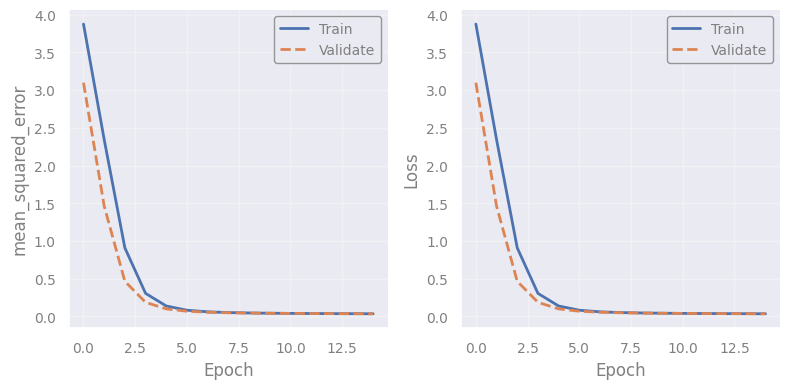

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0358 - mean_absolute_error: 0.1490 - mean_squared_error: 0.0358 - val_loss: 0.0358 - val_mean_absolute_error: 0.1484 - val_mean_squared_error: 0.0358


'00:00:12'

In [14]:
start_time = time.time() 

history=model.fit(X_train, y_train, 
                    batch_size=512, 
                    epochs=15,
                    validation_data=[ X_valid, y_valid],
                    callbacks=[plot_losses],shuffle=True)

# to print history contents
# history.history
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

## ... and the moment of truth - evaluation

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** evaluate the model (take care on which dataset!) 
    
</div>


In [15]:
evaluation = model.evaluate(X_test, y_test)
print(f"Loss value: {evaluation[0]:.2f}")  
for m in range(len(test_metrics)):
    print(f"{test_metrics[m]}: {evaluation[m+1]:0.2f}")  


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0356 - mean_absolute_error: 0.1490 - mean_squared_error: 0.0356
Loss value: 0.04
mean_squared_error: 0.04
mean_absolute_error: 0.15


## Comparing with a baseline model...

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** fill in the code to train and evaluate the baseline model.
    
</div>


In [16]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_hat_lr = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_hat_lr)
mae = mean_absolute_error(y_test, y_hat_lr)
r2 = r2_score( y_test , y_hat_lr)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 : {r2:.2f}" )

MSE: 0.12
MAE: 0.27
R2 : 0.97


## Checking the predicitons

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** fill in the code to check the results.
    
</div>


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step


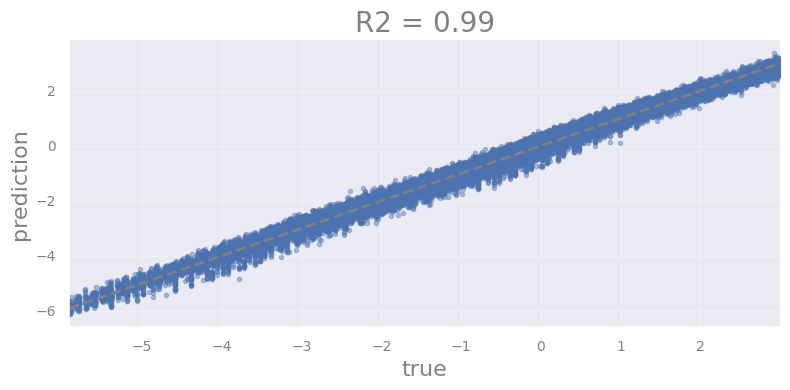

In [17]:
y_hat = model.predict( X_test)    

r2 = r2_score( y_test , y_hat)

min_ax, max_ax = np.min(y_test), np.max(y_test)

plt.plot(y_test, y_hat, '.', alpha=0.4)
plt.title( f'R2 = {r2:0.2f}', fontsize=20)
plt.xlabel('true', fontsize=16)
plt.ylabel('prediction', fontsize=16)
plt.xlim([min_ax, max_ax])

# 1-to-1 line:
xx = np.linspace(min_ax, max_ax, 100)
plt.plot(xx, xx, c="grey", linestyle='--')

plt.show()

# Application 2: Estimate SFR and stellar mass

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
<font size=4>**Exercise 2:**</font>    

**Objective:** Build a regression model to predict both SFR ('sfr') and stellar mass ('mstar').

**Task:** Follow the same steps with the previous exercise. You need to adjust the model to train and predict both values.

</div>


In this case we want to use all/part of the available features to estimate both the SFR (`sfr`) **and** the stellar mass (`mstar`). 

Reminder of the available features:

In [18]:
print(data_fits[1].columns)

ColDefs(
    name = 'sfr'; format = 'D'
    name = 'mstar'; format = 'D'
    name = 'IRX'; format = 'D'
    name = 'EBVs'; format = 'D'
    name = 'LYoungOld'; format = 'D'
    name = 'NIR200'; format = 'D'
    name = 'MIRI2100'; format = 'D'
    name = 'W1'; format = 'D'
    name = 'W2'; format = 'D'
    name = 'W3'; format = 'D'
    name = 'W4'; format = 'D'
)


<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** Select the features to work with. The features we want to predict now are two, the SFR and the stellar mass.
    
</div>




In [27]:
sel_features = ['LYoungOld', 'IRX', 'W1']
pre_features = ['sfr', 'mstar']

values = data_tab[sel_features].as_array()
values = values.view((float, len(values.dtype.names)))

target = data_tab[pre_features].as_array()
target = target.view((float, len(target.dtype.names)))


print('The values for selected features:')
print(values)
print()
print('The target quantity:')
print(target)


The values for selected features:
[[-1.16158268e+00  1.05970664e+00  2.02838578e+01]
 [-3.09543854e+00  6.09052593e-01  1.83803868e+01]
 [-7.99300379e-03  1.90271560e+00  2.12347368e+01]
 ...
 [-9.41034386e-01  1.06892832e+00  1.93644331e+01]
 [-2.68476354e+00  1.28714579e+00  2.24165564e+01]
 [ 4.02206145e-01  1.78640711e+00  2.03338382e+01]]

The target quantity:
[[-1.77759587  8.88439002]
 [-5.5981501   7.16347577]
 [ 0.4602692   9.55525251]
 ...
 [-2.56037601  8.2272979 ]
 [-1.62659848 11.23385302]
 [-0.28624628  8.25822978]]


<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Tasks:** 

- split the sample into train/validation/test

- what should you do before training the model?
    
</div>


In [28]:
# keep aside the test set first (coming from the future!)
X_train_full, X_test_un, y_train_full, y_test = train_test_split( values, target,
                        test_size=0.3) #, random_state=42) 

# split the remaining sample intro train and validation 
X_train_un, X_valid_un, y_train, y_valid = train_test_split( X_train_full, y_train_full,
                        test_size=0.2) #, random_state=42) 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_un)
X_valid = scaler.transform(X_valid_un)
X_test = scaler.transform(X_test_un)

print(f'> From {len(target)} sources:')
print(f'   {len(X_train)} (train)')
print(f'   {len(X_valid)} (validation)')
print(f'   {len(X_test)} (test)') 
print('\n> Statistics per feature:')
print(f'Mean: {scaler.mean_}')
print(f'Variance: {scaler.var_}')
print()
print(f' Target shape: {y_train.shape}') # print the shape of the output values


> From 123908 sources:
   69388 (train)
   17347 (validation)
   37173 (test)

> Statistics per feature:
Mean: [-0.54771319  1.46924353 20.83717469]
Variance: [1.45429263 0.14122995 2.26220365]

 Target shape: (69388, 2)


We define the metrics again here:

In [29]:
# if you want to add more output metrics
test_metrics = ['mean_squared_error', 'mean_absolute_error', ]


<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** Building our new model. Watch out the number of nodes at the very last step!
    
</div>


In [30]:
model = Sequential()

model.add( Dense(128, input_shape=X_train.shape[1:], activation='relu') )
model.add( Dense(64, activation='relu') )
model.add( Dense(32, activation='relu') )

model.add( Dense(2) )

In [31]:
optzr =  Adam(learning_rate=1e-4)
model.compile(loss= 'mean_squared_error',  # custom_loss, 
              optimizer=optzr, 
              metrics = test_metrics)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,914 (42.63 KB)

 Trainable params: 10,914 (42.63 KB)

 Non-trainable params: 0 (0.00 B)

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** Train the model
    
</div>


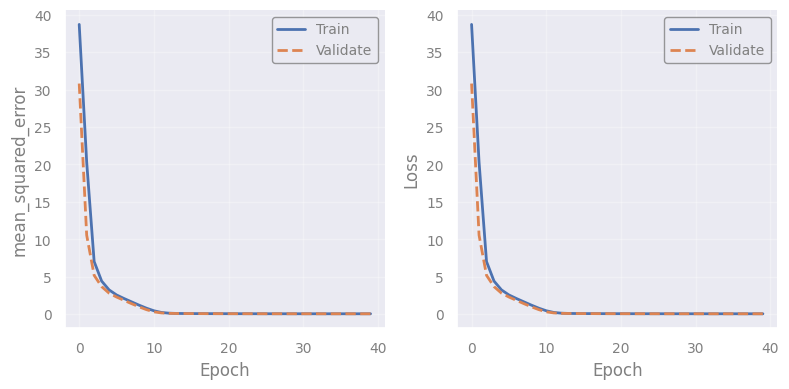

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0376 - mean_absolute_error: 0.1491 - mean_squared_error: 0.0376 - val_loss: 0.0376 - val_mean_absolute_error: 0.1486 - val_mean_squared_error: 0.0376


'00:00:33'

In [32]:
start_time = time.time() 

history=model.fit(X_train, y_train, 
                    batch_size=512, 
                    epochs=40,
                    validation_data=[ X_valid, y_valid],
                    callbacks=[plot_losses],shuffle=True)

# to print history contents
# history.history
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** Compare with baseline model.
    
</div>


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_hat_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_hat_lr)
mae_lr = mean_absolute_error(y_test, y_hat_lr)
r2_lr = r2_score(y_test, y_hat_lr, multioutput='raw_values')
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"R2 (sfr): {r2_lr[0]:0.2f} ")
print(f"R2 (mstar): {r2_lr[1]:0.2f} ")


Mean Squared Error (MSE): 0.10
Mean Absolute Error (MAE): 0.24
R2 (sfr): 0.97 
R2 (mstar): 0.97 



<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
  
**Task:** Check the results (with the linear modeling)
    
</div>


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0378 - mean_absolute_error: 0.1491 - mean_squared_error: 0.0378
Loss value: 0.04
mean_squared_error: 0.04
mean_absolute_error: 0.15
------
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step
0 0.992107521535609
1 0.9803644485134022


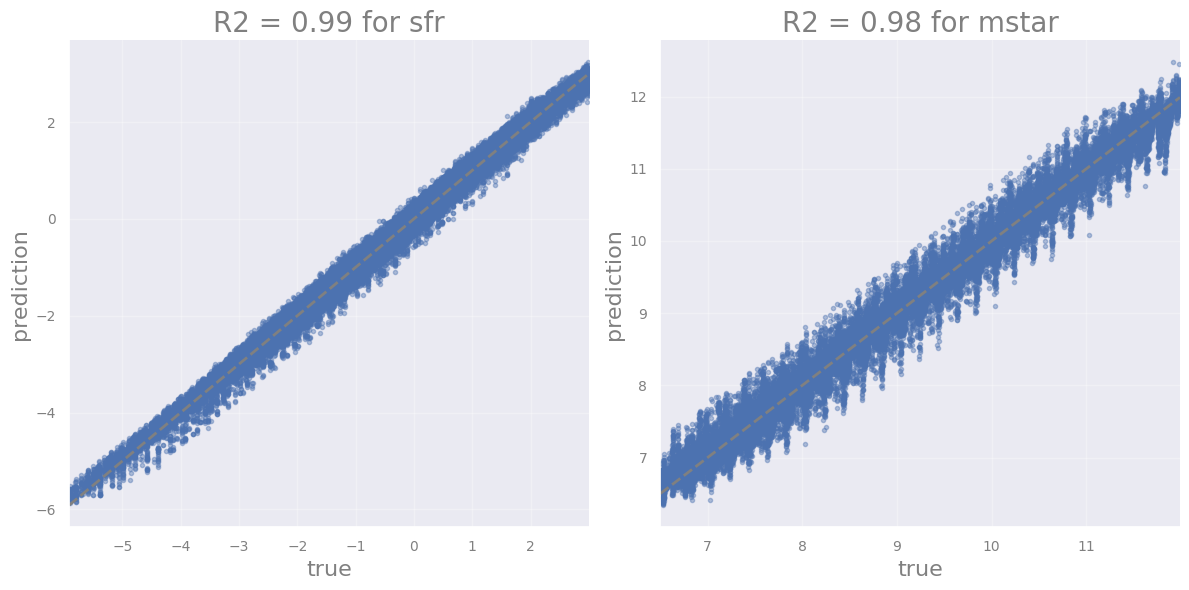

In [34]:
from sklearn.metrics import r2_score

evaluation = model.evaluate(X_test, y_test)
print(f"Loss value: {evaluation[0]:.2f}")  
for m in range(len(test_metrics)):
    print(f"{test_metrics[m]}: {evaluation[m+1]:0.2f}")  

print('------')

y_pred = model.predict( X_test) 

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes = axes.flatten()

for i, ax in enumerate(axes):
  
    r2 = r2_score( y_test[:,i] , y_pred[:,i])
    print(i, r2)
    
    min_ax, max_ax = np.min(y_test[:,i]), np.max(y_test[:,i])

    ax.plot(y_test[:,i], y_pred[:,i], '.', alpha=0.4)
    ax.set_title( f'R2 = {r2:0.2f} for {pre_features[i]}', fontsize=20)
    ax.set_xlabel('true', fontsize=16)
    ax.set_ylabel('prediction', fontsize=16)
    ax.set_xlim([min_ax, max_ax])

    min_ax, max_ax = np.min(y_test[:,i]), np.max(y_test[:,i])
    # 1-to-1 line:
    xx = np.linspace(min_ax, max_ax, 100)
    ax.plot(xx, xx, c="grey", linestyle='--')
    

plt.show()

In [ ]:
# EOF